In [17]:
import torch
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import random_split,DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.models as models
import seaborn as sns

In [18]:
device = ('mps' if torch.mps.is_available() else 'cpu' )
device

'mps'

### Load Data

In [19]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [20]:
dataset_path = 'dataset'
dataset = datasets.ImageFolder(root=dataset_path,transform=transform)

In [21]:
len(dataset)

2300

In [22]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [23]:
train_size = int(len(dataset)*0.75)
test_size = len(dataset)-train_size

In [24]:
train_dataset,val_dataset = random_split(dataset,[train_size,test_size])

In [25]:
len(train_dataset),len(val_dataset)

(1725, 575)

In [26]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [27]:
len(train_loader)

54

In [28]:
image,label = next(iter(train_loader))
image[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.058070064..1.11].


Text(0.5, 1.0, 'R_Crushed')

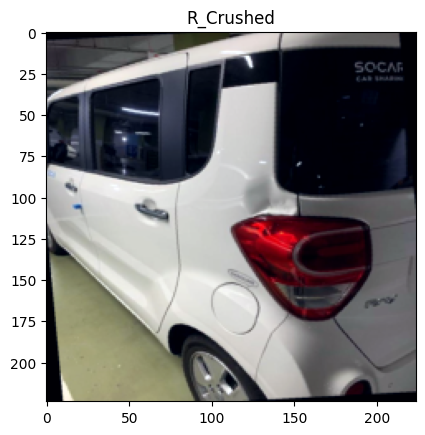

In [29]:
img = image[3]*0.25 + 0.45
lbl = label[3].item()
plt.imshow(img.permute(1,2,0))
plt.title(dataset.classes[lbl])

In [30]:
def imshow(img):
    img = img*0.25 + 0.5
    img = img.permute(1,2,0)
    plt.figure(figsize=(14,2))
    plt.imshow(img)
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029475987..1.1600001].


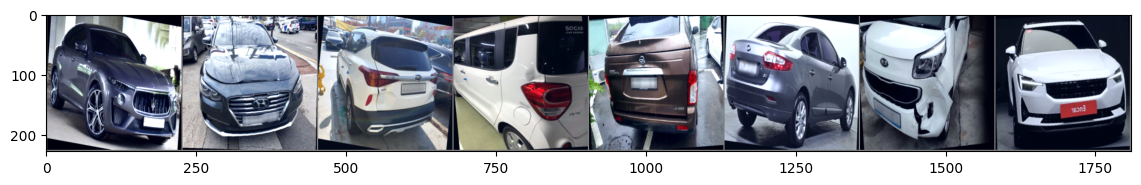

In [31]:
imshow(torchvision.utils.make_grid(image[:8]))

In [32]:
len(train_loader.dataset)

1725

### Training CNN

In [33]:
num_classes = len(dataset.classes)
num_classes

6

In [34]:
class carClassifierCNN(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1), #(16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1), #(32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), #(64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        return self.network(x)


In [35]:
len(train_loader.dataset)

1725

In [36]:
def train_model(model,train_loader,val_loader,criterion,optimiser,epochs=5):
    start = time.time()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch,(images,labels) in enumerate(train_loader):
            images,labels = images.to(device),labels.to(device)
            #forward pass
            outputs = model(images)
            loss = criterion(outputs,labels)
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            
            #weights updats
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            if (batch+1)%10 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch+1}, Loss: {loss.item():.2f}')
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader.dataset):.4f}')


        model.eval()
        all_pred = []
        all_true = []
        correct = 0
        total = 0
        with torch.no_grad():
            for images,labels in val_loader:
                images,labels = images.to(device),labels.to(device)
                outputs = model(images)
                _,pred = torch.max(outputs,1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                all_pred.extend(pred.cpu().numpy())
                all_true.extend(labels.cpu().numpy())

            print(f'*** Accuracy: {100*correct/total:.2f}% ***')
    end = time.time()
    print(f'Execution Time {end-start} seconds')
    return all_true, all_pred

In [37]:
num_classes

6

In [180]:
model = carClassifierCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

all_true,all_pred = train_model(model,train_loader,val_loader,criterion,optimizer,10)

Epoch: 1, Batch: 10, Loss: 1.80
Epoch: 1, Batch: 20, Loss: 1.67
Epoch: 1, Batch: 30, Loss: 1.68
Epoch: 1, Batch: 40, Loss: 1.58
Epoch: 1, Batch: 50, Loss: 1.54
Epoch [1/10], Loss: 1.8874
*** Accuracy: 33.91% ***
Epoch: 2, Batch: 10, Loss: 1.54
Epoch: 2, Batch: 20, Loss: 1.41
Epoch: 2, Batch: 30, Loss: 1.55
Epoch: 2, Batch: 40, Loss: 1.29
Epoch: 2, Batch: 50, Loss: 1.47
Epoch [2/10], Loss: 1.4434
*** Accuracy: 48.52% ***
Epoch: 3, Batch: 10, Loss: 1.24
Epoch: 3, Batch: 20, Loss: 1.21
Epoch: 3, Batch: 30, Loss: 1.30
Epoch: 3, Batch: 40, Loss: 1.18
Epoch: 3, Batch: 50, Loss: 1.22
Epoch [3/10], Loss: 1.2420
*** Accuracy: 48.87% ***
Epoch: 4, Batch: 10, Loss: 1.25
Epoch: 4, Batch: 20, Loss: 1.07
Epoch: 4, Batch: 30, Loss: 1.22
Epoch: 4, Batch: 40, Loss: 1.15
Epoch: 4, Batch: 50, Loss: 1.17
Epoch [4/10], Loss: 1.1733
*** Accuracy: 53.39% ***
Epoch: 5, Batch: 10, Loss: 1.32
Epoch: 5, Batch: 20, Loss: 1.15
Epoch: 5, Batch: 30, Loss: 0.91
Epoch: 5, Batch: 40, Loss: 1.38
Epoch: 5, Batch: 50, Los

### Training CNN with Normalizartion
* Batch Norm
* Dropout 
* L2 Regularization

In [181]:
class carClassifierCNNWithReg(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,stride=1,padding=1), #(16,224,224)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(16,112,112)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1), #(32,112,112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(32,56,56)
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), #(64,56,56)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),   #(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )
    def forward(self,x):
        return self.network(x)


In [182]:
model = carClassifierCNNWithReg(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4)

all_true,all_pred = train_model(model,train_loader,val_loader,criterion,optimizer,10)

Epoch: 1, Batch: 10, Loss: 16.51
Epoch: 1, Batch: 20, Loss: 6.35
Epoch: 1, Batch: 30, Loss: 2.61
Epoch: 1, Batch: 40, Loss: 1.51
Epoch: 1, Batch: 50, Loss: 1.76
Epoch [1/10], Loss: 8.7165
*** Accuracy: 40.87% ***
Epoch: 2, Batch: 10, Loss: 1.62
Epoch: 2, Batch: 20, Loss: 1.48
Epoch: 2, Batch: 30, Loss: 1.65
Epoch: 2, Batch: 40, Loss: 1.49
Epoch: 2, Batch: 50, Loss: 1.38
Epoch [2/10], Loss: 1.5231
*** Accuracy: 41.57% ***
Epoch: 3, Batch: 10, Loss: 1.17
Epoch: 3, Batch: 20, Loss: 1.59
Epoch: 3, Batch: 30, Loss: 1.49
Epoch: 3, Batch: 40, Loss: 1.45
Epoch: 3, Batch: 50, Loss: 1.60
Epoch [3/10], Loss: 1.4678
*** Accuracy: 47.48% ***
Epoch: 4, Batch: 10, Loss: 0.99
Epoch: 4, Batch: 20, Loss: 1.73
Epoch: 4, Batch: 30, Loss: 1.27
Epoch: 4, Batch: 40, Loss: 1.29
Epoch: 4, Batch: 50, Loss: 1.34
Epoch [4/10], Loss: 1.3871
*** Accuracy: 45.22% ***
Epoch: 5, Batch: 10, Loss: 1.50
Epoch: 5, Batch: 20, Loss: 1.22
Epoch: 5, Batch: 30, Loss: 1.21
Epoch: 5, Batch: 40, Loss: 1.53
Epoch: 5, Batch: 50, Lo

### Transfer Learning with EfficientNet

In [40]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [41]:
#taking feature extractin layer from pretrained net 
#adjusting fc layer as per our no.of output layer

In [42]:
class carClassifierCNNEffNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.model = models.efficientnet_b0(weights='DEFAULT')

        #freezing all layers except fc layer
        for param in self.model.parameters():         #freezing all feature extraction layer don't retrain it
            param.requires_grad = False
            
        in_features = self.model.classifier[1].in_features
        
        self.model.classifier = nn.Sequential(          #model.classifier => fc last layer (Effnet only contains 1 layer in fc)
            nn.Dropout(0.5),
            nn.Linear(in_features,num_classes)
        )
    def forward(self,x):
        return self.model(x)

In [203]:
model = carClassifierCNNEffNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda x:x.requires_grad, model.parameters()),lr=0.001)     #pass only those parameter i.e weights which we want to train

all_true,all_pred = train_model(model,train_loader,val_loader,criterion,optimizer,10)

Epoch: 1, Batch: 10, Loss: 1.72
Epoch: 1, Batch: 20, Loss: 1.50
Epoch: 1, Batch: 30, Loss: 1.54
Epoch: 1, Batch: 40, Loss: 1.37
Epoch: 1, Batch: 50, Loss: 1.22
Epoch [1/10], Loss: 1.4658
*** Accuracy: 57.57% ***
Epoch: 2, Batch: 10, Loss: 0.93
Epoch: 2, Batch: 20, Loss: 0.92
Epoch: 2, Batch: 30, Loss: 1.19
Epoch: 2, Batch: 40, Loss: 1.00
Epoch: 2, Batch: 50, Loss: 1.02
Epoch [2/10], Loss: 1.1245
*** Accuracy: 61.91% ***
Epoch: 3, Batch: 10, Loss: 1.08
Epoch: 3, Batch: 20, Loss: 1.17
Epoch: 3, Batch: 30, Loss: 1.12
Epoch: 3, Batch: 40, Loss: 1.13
Epoch: 3, Batch: 50, Loss: 1.05
Epoch [3/10], Loss: 1.0132
*** Accuracy: 65.39% ***
Epoch: 4, Batch: 10, Loss: 0.85
Epoch: 4, Batch: 20, Loss: 0.96
Epoch: 4, Batch: 30, Loss: 0.86
Epoch: 4, Batch: 40, Loss: 0.83
Epoch: 4, Batch: 50, Loss: 1.02
Epoch [4/10], Loss: 0.9618
*** Accuracy: 67.13% ***
Epoch: 5, Batch: 10, Loss: 1.04
Epoch: 5, Batch: 20, Loss: 1.07
Epoch: 5, Batch: 30, Loss: 1.04
Epoch: 5, Batch: 40, Loss: 0.93
Epoch: 5, Batch: 50, Los

### Transfer Learning withh ResNet

In [43]:
model = models.resnet50(weights='DEFAULT')
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [44]:
class carClassifierCNNResNet(nn.Module):
    def __init__(self,num_classes,dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')

        #freezing all layers except fc layer
        for param in self.model.parameters():
            param.requires_grad = False

        #unfreezing layer4 we need to train it
        for param in self.model.layer4.parameters():
            param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features,num_classes)
        )
    def forward(self,x):
        return self.model(x)
        

In [214]:
model = carClassifierCNNResNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda x:x.requires_grad,model.parameters()),lr=0.001)

all_true,all_pred = train_model(model,train_loader,val_loader,criterion,optimizer,10)

Epoch: 1, Batch: 10, Loss: 1.03
Epoch: 1, Batch: 20, Loss: 0.72
Epoch: 1, Batch: 30, Loss: 0.76
Epoch: 1, Batch: 40, Loss: 0.64
Epoch: 1, Batch: 50, Loss: 0.73
Epoch [1/10], Loss: 0.8793
*** Accuracy: 70.61% ***
Epoch: 2, Batch: 10, Loss: 0.43
Epoch: 2, Batch: 20, Loss: 0.54
Epoch: 2, Batch: 30, Loss: 0.44
Epoch: 2, Batch: 40, Loss: 0.51
Epoch: 2, Batch: 50, Loss: 0.46
Epoch [2/10], Loss: 0.5074
*** Accuracy: 81.22% ***
Epoch: 3, Batch: 10, Loss: 0.27
Epoch: 3, Batch: 20, Loss: 0.43
Epoch: 3, Batch: 30, Loss: 0.24
Epoch: 3, Batch: 40, Loss: 0.40
Epoch: 3, Batch: 50, Loss: 0.53
Epoch [3/10], Loss: 0.3582
*** Accuracy: 76.35% ***
Epoch: 4, Batch: 10, Loss: 0.23
Epoch: 4, Batch: 20, Loss: 0.33
Epoch: 4, Batch: 30, Loss: 0.31
Epoch: 4, Batch: 40, Loss: 0.26
Epoch: 4, Batch: 50, Loss: 0.28
Epoch [4/10], Loss: 0.2670
*** Accuracy: 80.00% ***
Epoch: 5, Batch: 10, Loss: 0.07
Epoch: 5, Batch: 20, Loss: 0.14
Epoch: 5, Batch: 30, Loss: 0.24
Epoch: 5, Batch: 40, Loss: 0.16
Epoch: 5, Batch: 50, Los

### Implementing best param values from hyper parameter tuning

In [45]:
lr = 0.009
dropout_rate = 0.23

In [46]:
model = carClassifierCNNResNet(num_classes,dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda x:x.requires_grad,model.parameters()),lr=lr)

all_true,all_pred = train_model(model,train_loader,val_loader,criterion,optimizer,10)

Epoch: 1, Batch: 10, Loss: 1.13
Epoch: 1, Batch: 20, Loss: 0.92
Epoch: 1, Batch: 30, Loss: 0.78
Epoch: 1, Batch: 40, Loss: 0.38
Epoch: 1, Batch: 50, Loss: 0.92
Epoch [1/10], Loss: 0.9961
*** Accuracy: 66.43% ***
Epoch: 2, Batch: 10, Loss: 0.63
Epoch: 2, Batch: 20, Loss: 0.59
Epoch: 2, Batch: 30, Loss: 0.82
Epoch: 2, Batch: 40, Loss: 0.96
Epoch: 2, Batch: 50, Loss: 0.52
Epoch [2/10], Loss: 0.6025
*** Accuracy: 72.70% ***
Epoch: 3, Batch: 10, Loss: 0.42
Epoch: 3, Batch: 20, Loss: 0.38
Epoch: 3, Batch: 30, Loss: 0.42
Epoch: 3, Batch: 40, Loss: 0.51
Epoch: 3, Batch: 50, Loss: 0.43
Epoch [3/10], Loss: 0.5356
*** Accuracy: 57.22% ***
Epoch: 4, Batch: 10, Loss: 0.46
Epoch: 4, Batch: 20, Loss: 0.27
Epoch: 4, Batch: 30, Loss: 0.49
Epoch: 4, Batch: 40, Loss: 0.38
Epoch: 4, Batch: 50, Loss: 0.29
Epoch [4/10], Loss: 0.4700
*** Accuracy: 76.52% ***
Epoch: 5, Batch: 10, Loss: 1.78
Epoch: 5, Batch: 20, Loss: 0.46
Epoch: 5, Batch: 30, Loss: 0.52
Epoch: 5, Batch: 40, Loss: 0.58
Epoch: 5, Batch: 50, Los

In [47]:
from sklearn.metrics import classification_report
report = classification_report(all_true,all_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.70      0.79       122
           1       0.70      0.81      0.75       108
           2       0.80      0.88      0.84       124
           3       0.74      0.78      0.76        78
           4       0.63      0.64      0.63        77
           5       0.79      0.70      0.74        66

    accuracy                           0.76       575
   macro avg       0.76      0.75      0.75       575
weighted avg       0.77      0.76      0.76       575



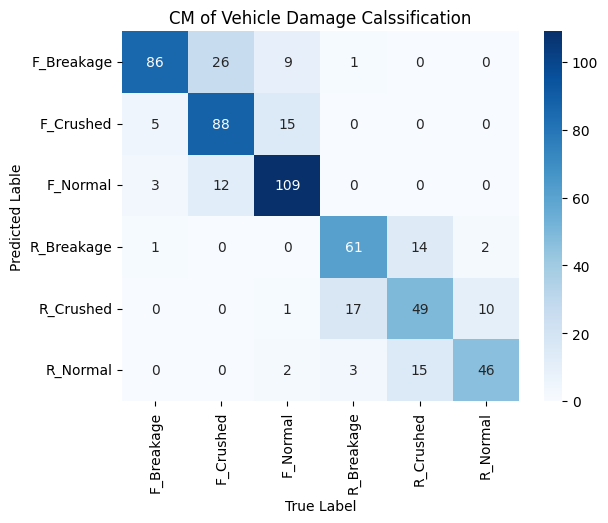

In [48]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
labels = dataset.classes
cm = confusion_matrix(all_true,all_pred)
sns.heatmap(cm,cmap='Blues',annot=True,fmt='d',xticklabels=labels,yticklabels=labels)
plt.xlabel('True Label')
plt.ylabel('Predicted Lable')
plt.title('CM of Vehicle Damage Calssification')
plt.show()

### Save Model

In [49]:
torch.save(model.state_dict(),'saved_model.pth')